In [24]:
# imports 
import time
import os, sys, glob
import cv2
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm.auto import tqdm
from PIL import Image, ImageFile
from importlib import reload
from torch.utils.data import DataLoader
from IPython.display import clear_output

# custom imports
sys.path.append('../')

from utils.GetLowestGPU import GetLowestGPU
from utils.GetLR import get_lr
import utils.BuildWNet as BuildWNet
import utils.WNetTileGenerator as TG
import utils.Loss as Loss

# get device
device = torch.device(GetLowestGPU(verbose=2))

# PIL options
ImageFile.LOAD_TRUNCATED_IMAGES = True

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 03550MiB / 40537MiB
  1  | 04518MiB / 40537MiB
  2  | 01724MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:3
---------------------------


# Load And Visualize Data

In [7]:
# define paths
image_path = '../data/train/images_by_pod/'

# load images and masks into list
# load image data
image_names = glob.glob(image_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

n_pad = 128

images = []
# VISUALIZE
for img_name in tqdm(image_names):
    # load image
    image = np.array(Image.open(image_path + img_name))
    image = (image[:, :, :3] / 255.0) # normalize image
    image = np.pad(image, ((n_pad, n_pad), (n_pad, n_pad), (0, 0)), 'edge') # pad image w/ values on edge
    images.append(image)

['adobe pods pod_j.png', 'pods_mid_600dpi_11.png', 'pods_early_600dpi_6.png', '89.ISU386_B.B.ISU Wild.W_1.png', '33.479-single.B.field 2023.W_9.png', 'pods_early_600dpi_15.png', 'pods_mid_600dpi_16.png', 'pods_early_600dpi_1.png', '89.ISU386_B.B.ISU Wild.W_6.png', 'pods_early_600dpi_12.png', '44.I1-2.B.GH 2023.W_10.png', 'pods_mid_600dpi_18.png', '89.ISU386_B.B.ISU Wild.W_8.png', '33.479-single.B.field 2023.W_0.png', 'adobe pods pod_c.png', 'pods_mid_600dpi_2.png', 'adobe pods pod_d.png', 'pods_mid_600dpi_5.png', 'pods_early_600dpi_8.png', '33.479-single.B.field 2023.W_7.png', 'pods_late_600dpi_2.png', 'pods_late_600dpi_31.png', '44.I1-2.B.GH 2023.W_8.png', 'pods_late_600dpi_36.png', 'pods_late_600dpi_5.png', 'pods_mid_600dpi_23.png', '44.I1-2.B.GH 2023.W_1.png', '8.tt8t x fc6-8.G.WBP-2022.W_3.png', '8.tt8t x fc6-8.G.WBP-2022.W_4.png', 'pods_mid_600dpi_24.png', '44.I1-2.B.GH 2023.W_6.png', '25.tt8t x fc5.B.WBP-2023.W_4.png', '25.tt8t x fc5.B.WBP-2023.W_3.png', 'pods_late_600dpi_29.png'

  0%|          | 0/164 [00:00<?, ?it/s]

In [29]:
reload(TG)
# instantiate tile generator
train_generator = TG.TileGenerator(images = images,
                                   tile_size = 224,
                                   split = 'train',
                                   n_pad = n_pad
                                   )

val_generator = TG.TileGenerator(images = images,
                                 tile_size = 224,
                                 split = 'val',
                                 n_pad = n_pad)

Plotting training examples...


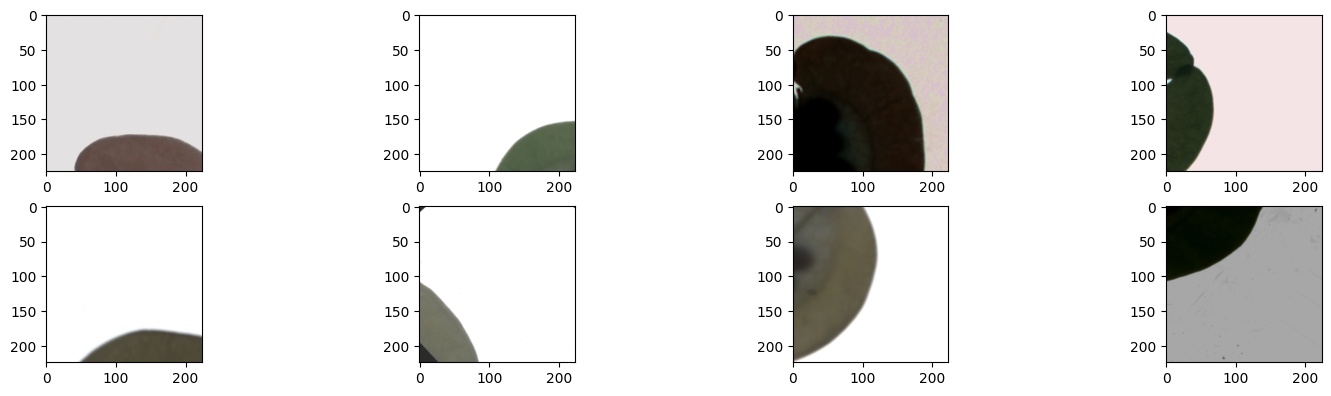

Plotting validation examples...


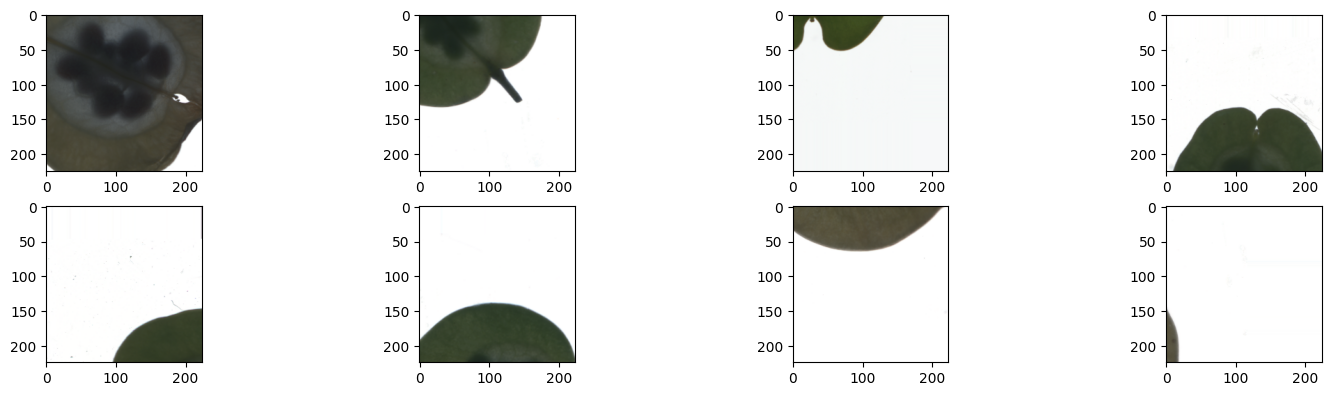

In [30]:
#plot
#plot random samples
figsize = 15
np.random.seed(0)
    
print('Plotting training examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(train_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    img, out = train_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()
    
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(img, vmin=0, vmax=1)

plt.tight_layout(pad=0.5)
plt.show()

print('Plotting validation examples...')
fig = plt.figure(figsize=(figsize, figsize/2))
N = len(val_generator)
for i in range(8):
    rand_idx = np.random.choice(N)

    img, out = val_generator[rand_idx]
    img = img.permute(1, 2, 0).numpy()

    ax = fig.add_subplot(4, 4, i+1)

    try:
        plt.imshow(img, vmin=0, vmax=1)
    except ValueError:  #raised if `y` is empty.
        pass

plt.tight_layout(pad=0.5)
plt.show()

# Create Model

In [31]:
# instantiate w-net
reload(BuildWNet)
wnet = BuildWNet.WNet().to(device)

# Train Model

In [32]:
#training loop

# create dataloaders
train_loader = DataLoader(train_generator, 
                          batch_size=32, 
                          shuffle=True,
                          num_workers=16)

val_loader = DataLoader(val_generator,
                        batch_size=32,
                        shuffle = True,
                        num_workers=16)

``

